# FINAL ASSIGNMENT (for handing in)

Model modification and extension with government spending following an exogenous AR(1) process and innvation shock.

In [97]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
plot = plt.plot

sigma = 1
eta = 2
kappa = 0.3
beta = 0.995
phi_pi = 1.5
phi_y = 0.1
rho_g = 0.7
gbar = 0.25 # parameter of the AR(1) process

### Task 1
Write the model in the form A*z_t = B with z_t = [y_t, pi_t, i_t]'

As in the assignments I rewrite the model so that every variable of time t is on the left hand side.
Then I define A and B so that A*z_t = B.

## !! ad info about how g_t is handled !!

In [5]:
A = np.array([[1,0,(1-gbar)*(1/sigma)],
            [-kappa*(sigma/(1-gbar)+eta),1,0],
            [-phi_y, -phi_pi,1]])
A_inv = np.linalg.inv(A)
A

array([[ 1.  ,  0.  ,  0.75],
       [-1.  ,  1.  ,  0.  ],
       [-0.1 , -1.5 ,  1.  ]])

array([[ 1.  ,  0.  ,  0.75],
       [ -1.  ,  1.  ,  0.  ],
       [-0.1 , -1.5 ,  1.  ]])

### Task 2

Write a function, similar to the one in Assignment 2, that has as input a vector that contains ’guessed values’ of c_g and c_eta_g and gives expectations for next periods Y, pi and g.

In [30]:
# input: 'guessed values' of C_g and C_eta_g_t

def model2(coef):
    c_outcome = np.zeros(len(coef))
    B = np.zeros(3)
    c_g = coef[0:3]
    c_eta_gt = coef[3:6]
    # Calculate expectations of output, inflation and government spending via equation (6) 
    # form expectations via (6): exp_z_t = C_g * g_t + C_eta_g * 0 since exp_eta = 0 (white noise). 
    # hence we need g_t which we can take from (4). I move up the 'next, ...' -step: Set values for g_t-1 and eta_g_t:
    exp_eta_gt = 0
    eta_gt = 0.1
    g_previous = 1

    # Part 1 without shock
    g_t = rho_g * g_previous
    exp_z_t = np.dot(c_g,g_t) + np.dot(c_eta_gt,exp_eta_gt)

    expY = exp_z_t[0]
    expPi = exp_z_t[1]
    expi = exp_z_t[2]
    expG = rho_g * g_t

    # These expectation are plugged into the B vector
    B[0] = expY + (1-gbar)*1/sigma*expPi + gbar*(g_t+expG)
    B[1] = beta*expPi
    B[2] = 0
    # Calculate z_t = A_inv*B once with and without shock in B (plug (4) for g_t) to get C_g and C_eta_g_t
    c_outcome[0:3] = np.dot(A_inv,B)

    # Part 2: with shock
    g_t = rho_g * g_previous + eta_gt
    exp_z_t = np.dot(c_g,g_t) + np.dot(c_eta_gt,exp_eta_gt)

    expY = exp_z_t[0]
    expPi = exp_z_t[1]
    expi = exp_z_t[2]
    expG = rho_g * g_t

    # These expectation are plugged into the B vector
    B[0] = expY + (1-gbar)*1/sigma*expPi + gbar*(g_t+expG)
    B[1] = beta*expPi
    B[2] = 0
    # Calculate z_t = A_inv*B with shock in g_t
    c_outcome[3:6] = np.dot(A_inv,B) - c_g

    # Caculate and return difference between C_g, C_eta_g_t and the input values
    difference = c_outcome - np.array(coef)
    return difference

init = [1.1, 0.1, 0.2, 0.1, 0.2, 0.1]
model2(init)

array([-0.62652557,  0.44312443,  0.66203409, -0.65888636,  0.32071364,
        0.68518182])

### Task 3: Run fsolve to get the rational expectation solution for c_g and c_eta_gt

In [75]:
init = [1.1, 0.1, 0.2, 0.1, 0.2, 0.1]

[coefficients, inf, ier, msg] = fsolve(model2, init, full_output = True)
print(coefficients, '\n', ier,'\n', msg)
C_g = coefficients[0:3]
C_eta_gt = coefficients[3:6]

print(C_g, '\n', C_eta_gt) 
# C_g = [0.12649155 0.41677611 0.63781333] 
# C_eta_gt = [0.01807022 0.05953944 0.09111619]

[0.12649155 0.41677611 0.63781333 0.01807022 0.05953944 0.09111619] 
 1 
 The solution converged.
[0.12649155 0.41677611 0.63781333] 
 [0.01807022 0.05953944 0.09111619]


### Task 4: Calculate the response to a shock on g_t of size 0.01

Make a loop for 40 periods and set the shock to 0.01 in the first period, 0 in every other period.
In each period, calculate the variables in z_t using the vectors C_g and C_eta_gt.

In [92]:
N = 40

eta_g = np.zeros(N)
eta_g[0] = 0.01
Y = np.zeros(N)
Pi = np.zeros(N)
ni = np.zeros(N)
g = np.zeros(N)

for t in range(N):
    z = C_g*g[t-1] + C_eta_gt*eta_g[t]
    Y[t] = z[0]
    Pi[t] = z[1]
    ni[t] = z[2]
    g_previous = g[t-1]
    g[t] = rho_g * g_previous + eta_g[t]

print(Y,'\n',Pi,'\n',ni,'\n',g)

[1.80702215e-04 1.26491551e-03 8.85440855e-04 6.19808598e-04
 4.33866019e-04 3.03706213e-04 2.12594349e-04 1.48816044e-04
 1.04171231e-04 7.29198618e-05 5.10439032e-05 3.57307323e-05
 2.50115126e-05 1.75080588e-05 1.22556412e-05 8.57894882e-06
 6.00526417e-06 4.20368492e-06 2.94257944e-06 2.05980561e-06
 1.44186393e-06 1.00930475e-06 7.06513325e-07 4.94559327e-07
 3.46191529e-07 2.42334070e-07 1.69633849e-07 1.18743694e-07
 8.31205861e-08 5.81844103e-08 4.07290872e-08 2.85103610e-08
 1.99572527e-08 1.39700769e-08 9.77905384e-09 6.84533769e-09
 4.79173638e-09 3.35421547e-09 2.34795083e-09 1.64356558e-09] 
 [5.95394449e-04 4.16776114e-03 2.91743280e-03 2.04220296e-03
 1.42954207e-03 1.00067945e-03 7.00475615e-04 4.90332931e-04
 3.43233051e-04 2.40263136e-04 1.68184195e-04 1.17728937e-04
 8.24102556e-05 5.76871789e-05 4.03810253e-05 2.82667177e-05
 1.97867024e-05 1.38506917e-05 9.69548417e-06 6.78683892e-06
 4.75078724e-06 3.32555107e-06 2.32788575e-06 1.62952002e-06
 1.14066402e-06 7.984

### Task 5
Make a figures with four subfigures where you plot the impulse responses that you have just calculated. The subfigures should contain the 4 variables in zt. Make sure that:
- All lines are dashed;
- Each line in a figure has a different color;
- The subfigures fit well in the figure.

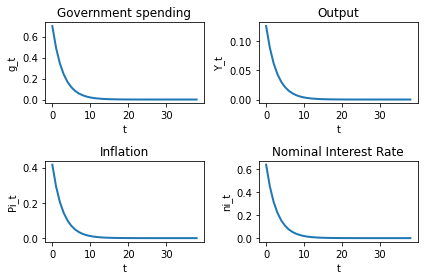

In [96]:
# at some point (which is not obvious in the assignment pdf as of March 1st) z_t became a 4x1 vector. 
# To plot all 4 variables, I did so starting from Task 4.
fig = plt.figure()

plt.subplot(2,2,1)
plot([g[i]*100 for i in range(1,N)], linewidth = 2)
plt.title('Government spending')
plt.ylabel('g_t')
plt.xlabel('t')

plt.subplot(2,2,2)
plot([Y[i]*100 for i in range(1,N)], linewidth = 2)
plt.title('Output')
plt.ylabel('Y_t')
plt.xlabel('t')

plt.subplot(2,2,3)
plot([Pi[i]*100 for i in range(1,N)], linewidth = 2)
plt.title('Inflation')
plt.ylabel('Pi_t')
plt.xlabel('t')

plt.subplot(2,2,4)
plot([ni[i]*100 for i in range(1,N)], linewidth = 2)
plt.title('Nominal Interest Rate')
plt.ylabel('ni_t')
plt.xlabel('t')

plt.tight_layout()

### Task 6: Give economic intuition for all variables.

- G is directly effected by the shock. Since rho_g is smaller than 1 and there is not any shock after t0, the government spending declines until it is 0 again.
- Output increases analogously since it is per definition the sum of consumption and government spending. The negative effect of the real interest rate is not observable by the eye since quite small.
- From the assignment description: "The net effect of government spending on inflation hence is positive."; 
- The nominal interest rate follows inflation and output and therefore has a similar form to those plots.



### Task 7:
Define a new function that can perform the linear time iteration algorithm for any given model. Your function should have four input arguments. The first three input arguments should be the matrices A,M and D and the fourth input argument should be an initial guess for the matrix F. Your new function should return the solution for the matrices F and Q that satisfy z_t = F*z_(t- 1) + Q*u_t.

In [109]:
def model7(A,M,D,F):
    n = len(A[0]) # dynamic
    
    Fnew = np.zeros((n,n))
    Fnew = np.dot(np.linalg.inv(A-np.dot(M,F)),D)

    while np.max(np.abs(F-Fnew)) > 0.000001:
        F=Fnew
        Fnew = np.dot(np.linalg.inv(A-np.dot(M,F)),D)
    Q = np.linalg.inv(A-np.dot(M,Fnew))
    return Fnew,Q

### Task 8:
- Write model in form of (9) but extend z_t with government spending: z_t = [g_t, y_t, pi_t, ni_t].
- write down the 4x4 matrices A,M and D in your code
- Next, ’Call’ the function that you defined in the previous question with the 3 matrices that define our model and with an initial guess for F as input arguments

In [110]:
# I write the 4 equations as in Assignment 1 so that it is clear how the matrices must look to represent the model.
A = np.array([
            [-gbar,1,0,(1-gbar)/sigma],
            [kappa*gbar/(1-gbar), -kappa*sigma/(1-gbar),1,0],
            [0,-phi_y,-phi_pi,1],
            [1,0,0,0]])

# only expectations of output and inflation influence the model
M = np.array([
            [gbar,1,(1-gbar)/sigma,0],
            [0,0,beta,0],
            [0,0,0,0],
            [0,0,0,0]])
# only in (4), z_(t-1) is used (g_(t-1))
D = np.zeros((4,4))
D[3,0] = rho_g

F = np.ones((4,4))
model7(A,M,D,F)

(array([[0.7       , 0.        , 0.        , 0.        ],
        [0.3739021 , 0.        , 0.        , 0.        ],
        [0.26214345, 0.        , 0.        , 0.        ],
        [0.43060539, 0.        , 0.        , 0.        ]]),
 array([[ 0.        ,  0.        ,  0.        ,  1.        ],
        [ 0.6557377 , -0.73770492, -0.49180328,  0.53414614],
        [ 0.26229508,  0.70491803, -0.19672131,  0.37449119],
        [ 0.45901639,  0.98360656,  0.6557377 ,  0.6151514 ]]))

### Task 9: 
#### b) Interpret Fnew and Q

Fnew:<br>
-> each column describes the effect of one element in z_(t-1) on z_t.
The first column describes the effect of g_(t-1) on g_t, y_t, pi_t and ni_t (in that order). The same applies to the other columns, although they are zero. To get the total effect of e.g z_(t-1) on g_t, one would add up the first row multiplied with z_(t-1). 


Q: <br>
-> Q is the response to shocks. Each column corresponds to a shock to z_t. So the first column corresponds to a shock to g_t, the second to a shock on output, the third to a shock on inflation and the last to a shock on the nominal interest rate. For example we cann see that the effect of a shock on g_t, eta_gt is a one-to-one realtionship which makes intuitivly sense when looking at equation 4 of our model.


#### b) Also compare your results from question 3 with F and Q. Explain the similarities and/or differences that you observe:
The results are different, since F_new and Q are computed taking into account the effect of changes in government spending while C_g and C_eta_gt are computed assuming that both variables are exogenous shocks to output and inflation.
